# Imports 

In [1]:
import xarray as xr             # to open and manipulate data arrays 
import xskillscore as xs        # calculating skill scores
import climpred
import xesmf as xe              # regridding
import numpy as np
import pandas as pd
      
import os
from pathlib import Path

In [2]:
# Plot and mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Increase the size of the output figures
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
# To minimise the warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# PARAMETERS 

In [4]:
#Parameters 

stage_in = 'processed'
period = 'hindcasts'
provider = 'CDS'
GCM = 'ECMWF'
var_name = 'T2M'

reanalysis = 'ERA5'

### Domain for selection 

In [5]:
lat_min = -60 
lat_max = 40 
lon_min = 120 
lon_max = 240

In [6]:
local = True 

In [7]:
HOME = Path.home()

In [8]:
if local: 
    r_path = Path('research/Smart_Ideas')
else:
    r_path = Path('drives/auck_projects/END19101/Working')

In [9]:
r_path

PosixPath('research/Smart_Ideas')

### paths to the GCM forecasts (seasonal anomalies will be loaded)

In [10]:
dpath_gcm = HOME /  r_path / 'data'/ 'GCMs'/ 'processed' / period / provider / GCM / var_name

In [11]:
dpath_gcm

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M')

### path to the ERA5 reanalysis (seasonal anomalies will be loaded )

In [12]:
dpath_era = HOME / r_path / 'data' / 'REANALYSIS' / stage_in / reanalysis / var_name

In [13]:
dpath_era

PosixPath('/home/nicolasf/research/Smart_Ideas/data/REANALYSIS/processed/ERA5/T2M')

### list the files for the GCM outputs 

In [14]:
lfiles_gcm = list(dpath_gcm.glob(f"{GCM}_{var_name}_seasonal_anomalies_????_??.nc"))

In [15]:
lfiles_gcm.sort()

In [16]:
len(lfiles_gcm)

288

In [17]:
lfiles_gcm[0]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_1993_01.nc')

In [18]:
lfiles_gcm[-1]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_2016_12.nc')

### list the files for the ERA5 reanalyses 

In [19]:
lfiles_era = list(dpath_era.glob(f"{reanalysis}_seasonal_anomalies_{var_name}_????_??.nc"))

In [20]:
lfiles_era.sort()

In [21]:
len(lfiles_era)

454

### restrict the list of files to post 1993 

In [22]:
lfiles_era = [x for x in lfiles_era if int(x.name.split('_')[-2]) >= 1993]

In [23]:
len(lfiles_era)

288

In [24]:
lfiles_era[0]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/REANALYSIS/processed/ERA5/T2M/ERA5_seasonal_anomalies_T2M_1993_01.nc')

In [25]:
lfiles_era[-1]

PosixPath('/home/nicolasf/research/Smart_Ideas/data/REANALYSIS/processed/ERA5/T2M/ERA5_seasonal_anomalies_T2M_2016_12.nc')

### opens the GCM ensemble 

In [26]:
dset_gcm_ensemble = xr.open_mfdataset(lfiles_gcm, combine='nested', concat_dim='time')

In [27]:
dset_gcm_ensemble

<xarray.Dataset>
Dimensions:     (lat: 181, lon: 360, member: 25, step: 3, time: 288)
Coordinates:
    surface     int64 0
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * step        (step) int64 3 4 5
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 3), meta=np.ndarray>
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m         (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 25, 3, 181, 360), meta=np.ndarray>

### select the first 3 months period: step 3 = 4 months leadtime, i.e. init time 1993-01 for 1993-02 to 1993-04 average

In [28]:
dset_gcm_ensemble = dset_gcm_ensemble.sel(step=3)

### calculates the ensemble mean 

In [29]:
dset_gcm_em = dset_gcm_ensemble.mean('member')

In [30]:
dset_gcm_em

<xarray.Dataset>
Dimensions:     (lat: 181, lon: 360, time: 288)
Coordinates:
    surface     int64 0
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    step        int64 3
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m         (time, lat, lon) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

### set the time to be the actual forecast valid time instead of the initialisation time 

In [31]:
forecast_valid_time = pd.to_datetime(dset_gcm_em.time.data)

In [32]:
forecast_valid_time = forecast_valid_time.shift(3, freq='MS')

In [33]:
dset_gcm_em['time'] = forecast_valid_time

In [34]:
dset_gcm_ensemble['time'] = forecast_valid_time

### read the ERA 5 seasonal anomalies 

In [35]:
dset_era = xr.open_mfdataset(lfiles_era, combine='nested', concat_dim='time')

In [36]:
dset_era = dset_era.sel(time=slice('1993','2016'))

In [37]:
dset_era

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 288)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

### sort by latitude to go from -90 to 90 

In [38]:
dset_era = dset_era.sortby('latitude')

### rename the dimensions 

In [39]:
dset_era = dset_era.rename({'latitude':'lat', 'longitude':'lon'})

### interpolate 

### create the grid template, from the GCM 

In [40]:
grid_out = dset_gcm_em[['lat','lon']]

In [41]:
grid_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    surface  int64 0
    step     int64 3
Data variables:
    *empty*

### initialize the regridder

In [42]:
regridder = xe.Regridder(dset_era, grid_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_721x1440_181x360.nc


### now interpolate 

In [43]:
dset_era_interp = regridder(dset_era)

using dimensions ('lat', 'lon') from data variable t2m as the horizontal dimensions for this dataset.


### checks the dimensions 

In [44]:
dset_era_interp

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    t2m      (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [45]:
dset_gcm_em

<xarray.Dataset>
Dimensions:     (lat: 181, lon: 360, time: 288)
Coordinates:
    surface     int64 0
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    step        int64 3
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time        (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2017-03-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m         (time, lat, lon) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

### rechunk 

In [46]:
dset_gcm_em = dset_gcm_em.chunk({'time': -1, 'lat':6, 'lon':6}) 

In [47]:
dset_gcm_ensemble = dset_gcm_ensemble.chunk({'time': -1, 'lat':6, 'lon':6}) 

In [48]:
dset_era_interp = dset_era_interp.chunk({'time': -1, 'lat':6, 'lon':6}) 

In [49]:
sub_gcm_em = dset_gcm_em.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [50]:
sub_gcm_ensemble = dset_gcm_ensemble.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [51]:
sub_era_interp = dset_era_interp.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

### align along the time dimension

In [52]:
sub_gcm_em, sub_era_interp = xr.align(sub_gcm_em, sub_era_interp, join='inner', indexes=[0])

In [53]:
sub_gcm_ensemble, sub_era_interp = xr.align(sub_gcm_ensemble, sub_era_interp, join='inner', indexes=[0])

### Pearson's R 

In [54]:
r = xs.pearson_r(sub_era_interp, sub_gcm_em, "time")

In [55]:
r

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 121)
Coordinates:
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float64 -60.0 -59.0 -58.0 -57.0 -56.0 ... 37.0 38.0 39.0 40.0
    surface  int64 0
    step     int64 3
Data variables:
    t2m      (lat, lon) float64 dask.array<chunksize=(6, 6), meta=np.ndarray>

In [56]:
r.compute()

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 121)
Coordinates:
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float64 -60.0 -59.0 -58.0 -57.0 -56.0 ... 37.0 38.0 39.0 40.0
    surface  int64 0
    step     int64 3
Data variables:
    t2m      (lat, lon) float64 0.4172 0.4241 0.4324 ... 0.3801 0.3342 0.3264

In [74]:
r_seasonal = []
for m in range(1, 12 + 1): 
    era_m = sub_era_interp.sel(time=sub_era_interp.time.dt.month == m)
    gcm_m = sub_gcm_em.sel(time=sub_gcm_em.time.dt.month == m)
    r = xs.pearson_r(era_m, gcm_m, "time")
    r_seasonal.append(r)

In [89]:
r_seasonal = xr.concat(r_seasonal,dim=pd.RangeIndex(1, 13, name='month')) 

In [90]:
r_seasonal

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 121, month: 12)
Coordinates:
    surface  int64 0
    step     int64 3
  * lat      (lat) float64 -60.0 -59.0 -58.0 -57.0 -56.0 ... 37.0 38.0 39.0 40.0
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (month, lat, lon) float64 dask.array<chunksize=(1, 6, 6), meta=np.ndarray>

In [99]:
from calendar import month_abbr

In [ ]:
plt.Figure.subplots_adjust

In [105]:
int(m)

1

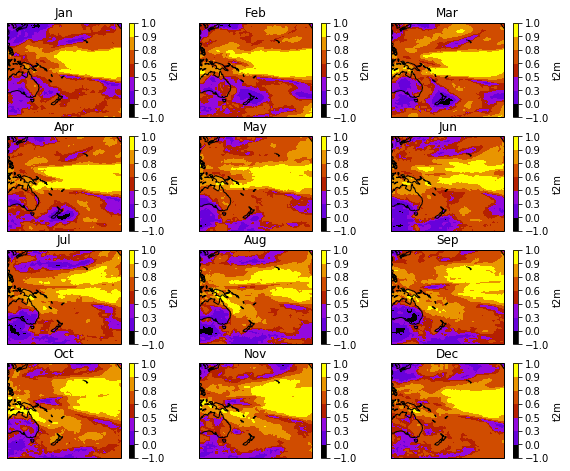

In [109]:
f, axes = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 8))

f.subplots_adjust(wspace=0.1, hspace=0.2)

axes = axes.flatten() 

for i, m in enumerate(r_seasonal.month): 
    r_seasonal['t2m'].sel(month=m).plot.contourf(vmin=-1, vmax=1, ax=axes[i], transform=ccrs.PlateCarree(), levels = [-1, 0, 0.3, 0.5, 0.6, 0.8, 0.9, 1], cmap = 'gnuplot')
    axes[i].coastlines();
    axes[i].set_title(month_abbr[int(m)])
    
f.savefig(f'./R_seasonal_{GCM}_{var_name}.png', dpi=200, bbox_inches='tight')

# 1.    Pearson correlation between observations and ensemble mean

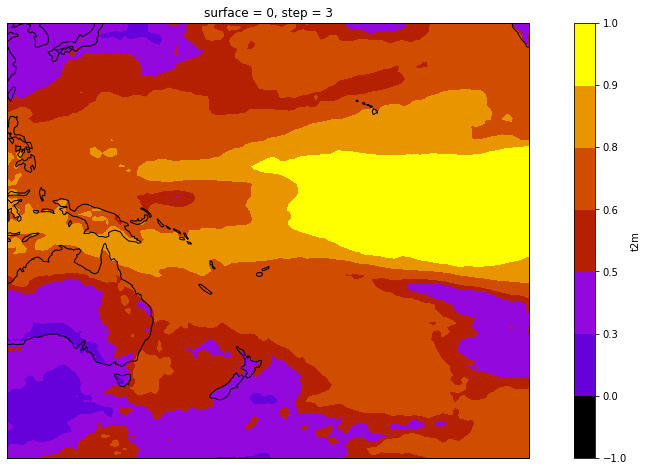

In [57]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
p = r[var_name.lower()].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = [-1, 0, 0.3, 0.5, 0.6, 0.8, 0.9, 1], cmap = 'gnuplot')
ax.coastlines();

# 2.    Continuous Ranked Probability score (CRPS)

In [58]:
crps_ensemble = xs.crps_ensemble(sub_era_interp, sub_gcm_ensemble)

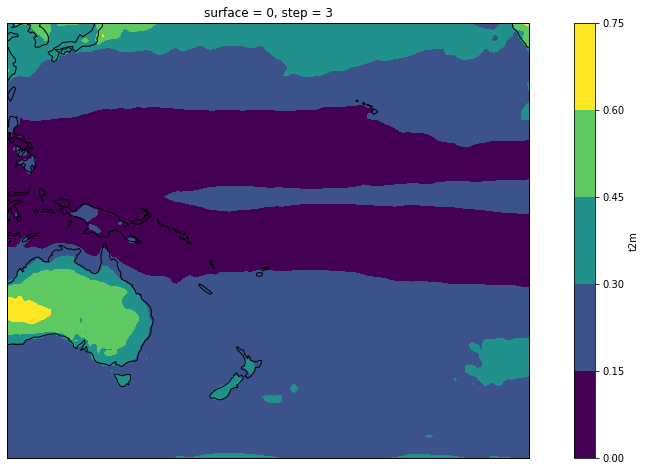

In [59]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
p = crps_ensemble[var_name.lower()].mean('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

# 3.    Brier Skill Score for the upper tercile

In [60]:
brier_score = xs.brier_score(sub_era_interp >  sub_era_interp.quantile(2/3, dim = 'time'), (sub_gcm_ensemble > sub_gcm_ensemble.quantile(2/3, dim = 'time')).mean("member"))

In [61]:
brier_score.compute()

<xarray.Dataset>
Dimensions:     (lat: 101, lon: 121, time: 285)
Coordinates:
  * time        (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * lon         (lon) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat         (lat) float64 -60.0 -59.0 -58.0 -57.0 ... 37.0 38.0 39.0 40.0
    quantile    float64 0.6667
    surface     int64 0
    step        int64 3
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-01-01
Data variables:
    t2m         (time, lat, lon) float64 0.64 0.64 0.5776 ... 0.36 0.2704 0.4096

In [62]:
baseline = xs.brier_score(sub_era_interp >  sub_era_interp.quantile(2/3, dim = 'time'), 2/3)

In [63]:
baseline.compute()

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 121, time: 285)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
    month     (time) int64 4 5 6 7 8 9 10 11 12 1 2 ... 2 3 4 5 6 7 8 9 10 11 12
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat       (lat) float64 -60.0 -59.0 -58.0 -57.0 ... 37.0 38.0 39.0 40.0
    quantile  float64 0.6667
Data variables:
    t2m       (time, lat, lon) float64 0.1111 0.1111 0.1111 ... 0.4444 0.4444

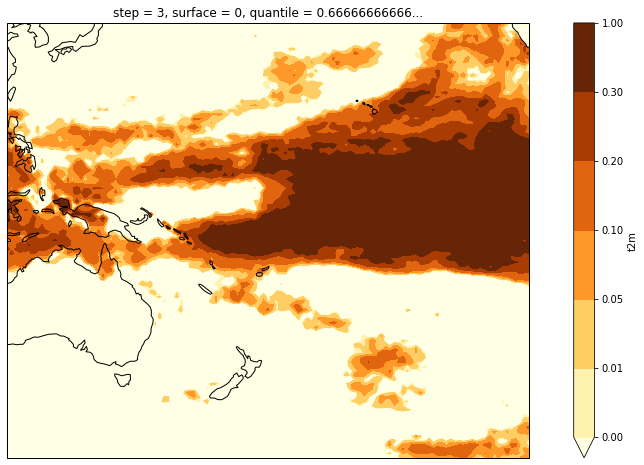

In [64]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
(1 - (brier_score/baseline)).mean(dim = 'time')[var_name.lower()].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3,  1], cmap = 'YlOrBr')
ax.coastlines();

# BRIER SCORE FOR THE LOWER TERCILE

In [112]:
brier_score = xs.brier_score(sub_era_interp <  sub_era_interp.quantile(1/3, dim = 'time'), (sub_gcm_ensemble < sub_gcm_ensemble.quantile(1/3, dim = 'time')).mean("member"))

In [113]:
brier_score.compute()

<xarray.Dataset>
Dimensions:     (lat: 101, lon: 121, time: 285)
Coordinates:
  * time        (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * lon         (lon) float64 120.0 121.0 122.0 123.0 ... 238.0 239.0 240.0
  * lat         (lat) float64 -60.0 -59.0 -58.0 -57.0 ... 37.0 38.0 39.0 40.0
    quantile    float64 0.3333
    surface     int64 0
    step        int64 3
    valid_time  (time) datetime64[ns] 1993-05-01 1993-06-01 ... 2017-01-01
Data variables:
    t2m         (time, lat, lon) float64 0.04 0.0576 0.0576 ... 0.0144 0.0064

In [114]:
baseline = xs.brier_score(sub_era_interp <  sub_era_interp.quantile(1/3, dim = 'time'), 1/3)

In [115]:
baseline.compute()

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 121, time: 285)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
    month     (time) int64 4 5 6 7 8 9 10 11 12 1 2 ... 2 3 4 5 6 7 8 9 10 11 12
  * lon       (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat       (lat) float64 -60.0 -59.0 -58.0 -57.0 ... 37.0 38.0 39.0 40.0
    quantile  float64 0.3333
Data variables:
    t2m       (time, lat, lon) float64 0.1111 0.1111 0.1111 ... 0.1111 0.1111

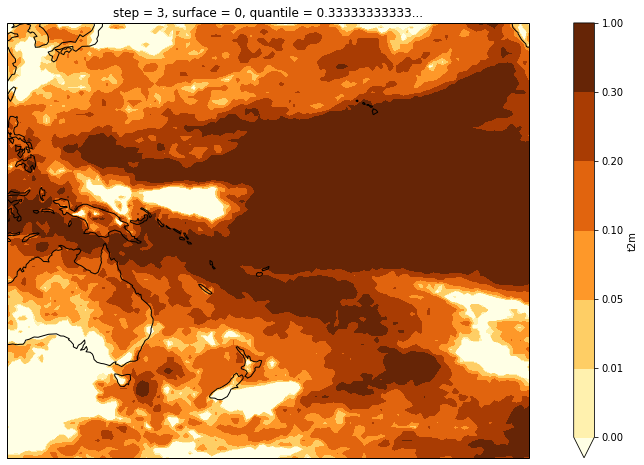

In [116]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
(1 - (brier_score/baseline)).mean(dim = 'time')[var_name.lower()].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3,  1], cmap = 'YlOrBr')
ax.coastlines();